# Look Ma, No For-Loops: Array Programming With NumPy

Source: https://realpython.com/numpy-array-programming/

In [236]:
import numpy as np
from IPython.display import Image

In [237]:
arr = np.arange(36).reshape(3,4,3)
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[24, 25, 26],
        [27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]]])

In [238]:
arr.shape

(3, 4, 3)

## What is Vectorization?

Vectorization is a powerful ability within NumPy to express operations as occuring on entire arrays rather than their individual elements.

In general, vectorized array operations will often be one or two (or more) orders of magnitude faster than their pure Python equivalents, with the biggest impact in any kind of numerical computations

As an illustration, consider a 1-dimensional vector of True and False for which you want to count the number of “False to True” transitions in the sequence:

In [239]:
np.random.seed(444)
x = np.random.choice([False, True], size=100000)
x

array([ True, False,  True, ...,  True, False,  True])

With a Python for-loop, one way to do this would be to evaluate, in pairs, the truth value of each element in the sequence along with the element that comes right after it:

In [240]:
def count_transitions(x) -> int:
    count = 0
    for i, j in zip(x[:-1], x[1:]):
        if j and not i:
            count += 1
    return count

count_transitions(x)

24984

In vectorized form, there’s no explicit for-loop or direct reference to the individual elements:

In [241]:
np.count_nonzero(x[:-1] < x[1:])

24984

How can I compare in terms of performance?

In [242]:
from timeit import timeit
setup = 'from __main__ import count_transitions, x; import numpy as np'
num = 1000
t1 = timeit('count_transitions(x)', setup=setup, number=num)
t2 = timeit('np.count_nonzero(x[:-1] < x[1:])', setup=setup, number=num)
print('t1: {t1}sec\nt2: {t2}sec\nspeed difference(t1/t2) {diff:0.2f}x'.format(t1=t1,t2=t2,diff=t1/t2))

t1: 6.6232909000027576sec
t2: 0.0918695000000298sec
speed difference(t1/t2) 72.09x


## Buy Low, Sell High

e.g.: Given a stock’s price history as a sequence, and assuming that you are only allowed to make one purchase and one sale, what is the maximum profit that can be obtained? For example, given prices = (20, 18, 14, 17, 20, 21, 15), the max profit would be 7, from buying at 14 and selling at 21.

In [243]:
# O(n) solution
def profit(prices) -> int:
#     if not isinstance(prices, list):
#         raise TypeError
    max_pf = 0
    min_pf = prices[0]
    for prc in prices[1:]:
        min_pf = min(min_pf, prc)
        max_pf = max(max_pf, prc - min_pf)
    return max_pf

prices = (20, 18, 14, 17, 20, 21, 15)
profit(prices)

7

How to do same thing in NumPy?

In [244]:
prices = np.full(100, fill_value=np.nan)
prices[[0,25,60,-1]] = [80., 30., 75., 50.]

x = np.arange(len(prices))
is_valid = ~np.isnan(prices)
prices = np.interp(x=x, xp=x[is_valid], fp=prices[is_valid])
prices += np.random.randn(len(prices)) * 2

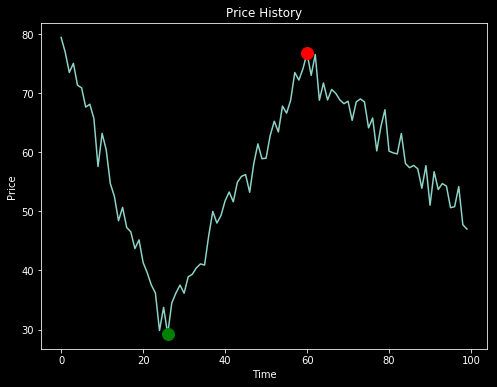

In [245]:
import matplotlib.pyplot as plt

# Warning! This isn't a fully correct solution, but it works for now.
# If the absolute min came after the absolute max, you'd have trouble.

mn = np.argmin(prices)
mx = mn + np.argmax(prices[mn:])
kwargs = {'marker':'o','markersize': 12, 'linestyle': ''}

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prices)
ax.set_title('Price History')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.plot(mn, prices[mn], color='green', **kwargs)
ax.plot(mx, prices[mx], color='red', **kwargs)

cummin is customized function to find cumulative minimum of array-like datatype

Extending the logic from the pure-Python example, you can find the difference between each price and a running minimum (element-wise), and then take the max of this sequence:

In [246]:
# cummin: cumulative minimum: it returns array of cumulative minimum
cummin = np.minimum.accumulate
cummin
def profit_with_numpy(prices):
    """Price minus cumulative minimum price, element-wise"""
    prices = np.asarray(prices)
    return np.max(prices - cummin(prices))

print(profit_with_numpy(prices))
print(np.allclose(profit_with_numpy(prices), profit(prices)))

47.51581018762879
True


Compare the time difference b/w profit function v.s. profit_with_numpy

In [247]:
seq = np.random.randint(0, 100, size=100000)
setup = 'from __main__ import profit_with_numpy, profit, seq;' ' import numpy as np'
num = 250
pytime = timeit('profit(seq)', setup=setup, number=num)
nptime = timeit('profit_with_numpy(seq)', setup=setup, number=num)
print(' pytime: {t1}sec\n nptime: {t2}sec\n {diff:0.2f}x'.format(t1=pytime, t2=nptime, diff=pytime/nptime))

 pytime: 10.772085600001446sec
 nptime: 0.061911199998576194sec
 173.99x


Above, treasting profit_with_numpy() as pseudocode (without considering NumPy's underlying mechanics), there are actually three passes through a sequence:

- cummin(prices) has O(n) time complexity
- prices - cummin(prices) is O(n)
- max(...) is O(n)

## Intermezzo: Understanding Axes Notation

in NumPy, an axis refers to a single dimension of a multidimensional array:

In [248]:
arr = np.array([[1,2,3],
               [10,20,30]])
print(arr.sum(axis=0))
print(arr.sum(axis=1))

[11 22 33]
[ 6 60]


#### axis  :  {'index' (0), 'columns' (1)}

** summing an array for axis=0 collapses the rows of the array with a column-wise computation. **

** summing an array for axis=1 collapses the columns of the array with a row-wise computation **

## Boradcasting


Broadcasting is another important NumPy abstraction. You’ve already seen that operations between two NumPy arrays (of equal size) operate element-wise:

In [249]:
a = np.array([1.5, 2.5, 3.5])
b = np.array([10., 5., 1.])
a/b

array([0.15, 0.5 , 3.5 ])

What about unequally sized array? This is where broadcasting comes in:

the term **broadcasting** describes how NumPy treats arrays with different shape during arithmetic operations. Subject to certain constraints, the smaller array is "broadcast" across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python

The way in which broadcasting is implemented can become tedious when working with more than two arrays. However, if there are just **two arrays**, then their ability to be broadcasted can be described with two short rules:

When operating on two arrays, NumPy compares their **shapes element-wise**. It starts with the **trailing dimensions and works its way forward**. Two dimensions are compatible when:

- they are equal, or
- one of them is 1

Let’s take a case where we want to subtract each column-wise mean of an array, element-wise:

In [250]:
sample = np.random.normal(loc=[2., 20.], scale=[1., 3.5], size=(3,2))
sample

array([[ 2.2261252 , 17.68916753],
       [ 1.91752374, 18.55904714],
       [ 2.88271815, 22.2076747 ]])

In statistical jargon, sample consists of two samples (the columns) drawn independently from two populations with means of 2 and 20, respectively. The column-wise means should approximate the population means (albeit roughly, because the sample is small):

In [251]:
mu = sample.mean(axis=0)
mu

array([ 2.34212236, 19.48529646])

In [252]:
print('sample:', sample.shape, '| means:', mu.shape)

sample: (3, 2) | means: (2,)


In [253]:
sample - mu

array([[-0.11599716, -1.79612893],
       [-0.42459862, -0.92624932],
       [ 0.54059578,  2.72237825]])

Here’s an illustration of subtracting out **column-wise means**, where a smaller array is “stretched” so that it is subtracted from each row of the larger array:

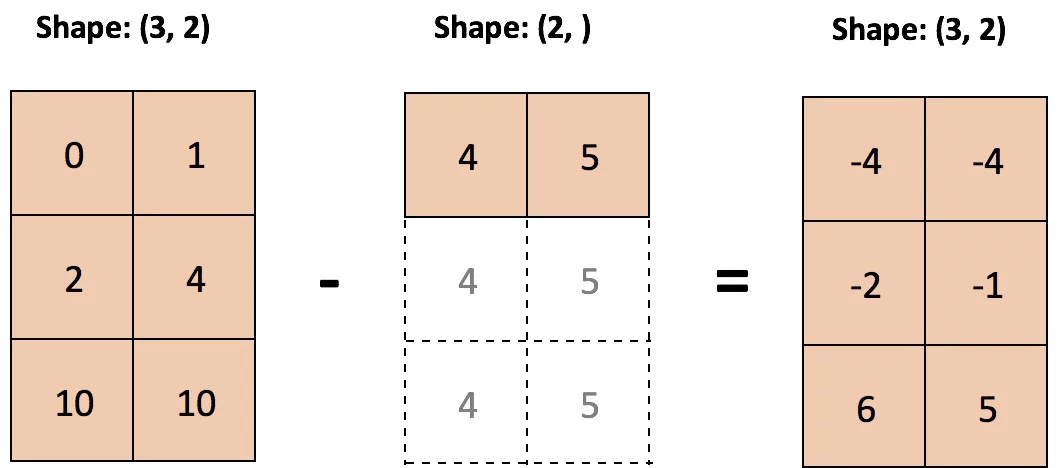

In [254]:
Image('broadcasting.jpg')

This extends to standardizing each column as well, making each cell a z-score relative to its respective column:

In [255]:
(sample - sample.mean(axis=0)) / sample.std(axis=0)

array([[-0.28820226, -0.91756501],
       [-1.05494207, -0.47318093],
       [ 1.34314433,  1.39074594]])

However, what if you want to subtract out, for some reason, the *row-wise minimums*? You’ll run into a bit of trouble:

In [256]:
sample.min(axis=1)

array([2.2261252 , 1.91752374, 2.88271815])

In [257]:
sample.min(axis=1).shape

(3,)

In [258]:
sample - sample.min(axis=1)

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

The problem here is that the smaller array, in its current form, cannot be “stretched” to be shape-compatible with sample. You actually need to expand its dimensionality to meet the broadcasting rules above:

In [259]:
sample.min(axis=1)[:,None]

array([[2.2261252 ],
       [1.91752374],
       [2.88271815]])

In [260]:
sample.min(axis=1)[:,None].shape

(3, 1)

In [261]:
sample - sample.min(axis=1)[:, None]

array([[ 0.        , 15.46304233],
       [ 0.        , 16.6415234 ],
       [ 0.        , 19.32495656]])

Note: **[:, None]** is a means by which to expand the dimensionality of an array, to create an axis of length one. np.newaxis is an alias for None

In [262]:
a = sample.min(axis=1)
a.shape

(3,)

In [263]:
a[:, None].shape

(3, 1)

In [276]:
a = np.sin(np.arange(10)[:, None])
print(a)
b = np.random.randn(1,10)
print(b)
c = np.full_like(a, 10)
print(c)
d = 8

[[ 0.        ]
 [ 0.84147098]
 [ 0.90929743]
 [ 0.14112001]
 [-0.7568025 ]
 [-0.95892427]
 [-0.2794155 ]
 [ 0.6569866 ]
 [ 0.98935825]
 [ 0.41211849]]
[[ 0.19708858 -1.26525903 -0.26600707 -1.09340275 -0.21704879  0.80720874
   0.58302912  0.05352656 -0.32479146  0.08947613]]
[[10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]
 [10.]]


In [267]:
arrays = [np.atleast_1d(arr) for arr in (a,b,c,d)]
for arr in arrays:
    print(arr.shape)

(10, 1)
(1, 10)
(10, 1)
(1,)


There are some significantly more complex cases, too. Here’s a more rigorous definition of when any arbitrary number of arrays of any shape can be broadcast together:

A set of arrays is called “broadcastable” to the same shape if the following rules produce a valid result, meaning one of the following is true:

1. The arrays all have exactly the same shape.

2. The arrays all have the same number of dimensions, and the length of each dimension is either a common length or 1.

3. The arrays that have too few dimensions can have their shapes prepended with a dimension of length 1 to satisfy property #2.

Check criterion #1

In [268]:
len(set(arr.shape for arr in arrays)) == 1

False

Check criterion #2

In [269]:
len (set((arr.ndim) for arr in arrays)) == 1

False

Final criterion is a bit more involved:

**The arrays that have too few dimensions can have their shapes prepended with a dimension of length 1 to satisfy property #2.**

In [270]:
maxdim = max(arr.ndim for arr in arrays)
shapes = np.array([(1,) * (maxdim - arr.ndim) + arr.shape for arr in arrays])
shapes

array([[10,  1],
       [ 1, 10],
       [10,  1],
       [ 1,  1]])

Finally, you need to test that the length of each dimension is either (drawn from) a common length, or 1. A trick for doing this is to first mask the array of “shape-tuples” in places where it equals one. Then, you can check if the peak-to-peak (np.ptp()) column-wise differences are all zero:

In [271]:
masked = np.ma.masked_where(shapes == 1, shapes)
np.all(masked.ptp(axis=0) == 0) # ptp: max - min

True

In [272]:
# Encapsulated in a single function, this logic looks like this:
def can_broadcast(*arrays) -> bool:
    arrays = [np.atleast_1d(arr) for arr in arrays]
    if len(set(arr.shape for arr in arrays)) == 1:
        return True
    elif len(set((arr.ndim) for arr in arrays)) == 1:
        return True
    maxdim = max(arr.ndim for arr in arrays)
    shapes = np.array([(1,) * (maxdim - arr.ndim) + arr.shape for arr in arrays])
    masked = np.ma.masked_where(shapes == 1, shapes)
    return np.all(masked.ptp(axis=0) == 0)

can_broadcast(a,b,c,d)

True

luckily, you can take a shortcut and use np.broadcast() for this sanity-check, although it’s not explicitly designed for this purpose:

In [273]:
def can_broadcast(*arrays) -> bool:
    try:
        np.broadcast(*arrays)
        return True
    except ValueError:
        return False

can_broadcast(a,b,c,d)

True